# Introduction

This notebook shows an example of relaxing the LiFePO4 crystal.

If you are running this notebook from Google Colab, uncomment the next code box to install m3gnet first.

In [20]:
# !pip install m3gnet
# !pip install ase
# !pip install pymatgen

In [1]:
import warnings

import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.util.coord import pbc_diff

from m3gnet.models import Relaxer

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")

In [9]:
mpr = MPRester("4HmCPQXiVVZmUjfuKNJSgE0G6MPLfTAA")
lfp = mpr.get_structure_by_material_id("mp-19017")  # This is LiFePO4.

lfp_strained = lfp.copy()  # We create a copy.
# Create a random strain between -5% and 5% for each direction
strains = np.random.uniform(low=-0.05, high=0.05, size=3)
lfp_strained.apply_strain(strains)
# In addition to the lattice strains, we also perturb the atoms by a distance of 0.1 angstrom.
lfp_strained.perturb(0.1)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
relaxer = Relaxer()
relax_results: dict
%time relax_results = relaxer.relax(lfp_strained)
relaxed_struct = relax_results["final_structure"]

CPU times: user 32.8 s, sys: 11.1 s, total: 43.9 s
Wall time: 38 s


Note that the relaxation only took < 20s.

The relaxation using the M3GNet universal IAP has brought the lattice parameters much closer to the original DFT ones and the coordinates are also within $10^{-3}$ of the original fractional coordinates.

In [11]:
print(f"Original lattice parameters are {[round(x, 3) for x in lfp.lattice.abc]}")
print(f"Strained lattice parameters are {[round(x, 3) for x in lfp_strained.lattice.abc]}")
print(f"Relaxed lattice parameters are {[round(x, 3) for x in relaxed_struct.lattice.abc]}")

Original lattice parameters are [10.236, 5.971, 4.655]
Strained lattice parameters are [10.0, 5.846, 4.655]
Relaxed lattice parameters are [10.465, 6.099, 4.749]


In [13]:
lfp_strained.frac_coords

array([[0.00412635, 0.9992362 , 0.98045385],
       [0.49395464, 0.48857139, 0.49068059],
       [0.49013589, 0.99846731, 0.4970481 ],
       [0.99714627, 0.51386495, 0.01098918],
       [0.77377559, 0.25510526, 0.54287878],
       [0.71418896, 0.74244399, 0.01339701],
       [0.28832944, 0.24323813, 0.9824459 ],
       [0.21547506, 0.73390022, 0.47056927],
       [0.09173845, 0.25987526, 0.43555921],
       [0.41024948, 0.75672711, 0.93628696],
       [0.60328166, 0.2522353 , 0.08804439],
       [0.90765483, 0.76632459, 0.57584919],
       [0.10143535, 0.25750812, 0.7332521 ],
       [0.83568041, 0.53333401, 0.69906799],
       [0.83410751, 0.96057379, 0.69367859],
       [0.9118232 , 0.74352686, 0.2702596 ],
       [0.0448614 , 0.75287   , 0.68871814],
       [0.39582703, 0.74849239, 0.24348735],
       [0.15677349, 0.0400748 , 0.29211687],
       [0.66741191, 0.46189415, 0.19469103],
       [0.33968782, 0.5552654 , 0.77316596],
       [0.3258744 , 0.94632026, 0.7926703 ],
       [0.

In [14]:
strained_to_orig_frac_coords_mean_diff = abs(pbc_diff(lfp_strained.frac_coords, lfp.frac_coords)).mean()

print(
    "mean diff in frac. coords. between strained and original "
    f"LFP structure: {strained_to_orig_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between strained and original LFP structure: 0.00817


In [15]:
orig_to_m3gnet_frac_coords_mean_diff = abs(pbc_diff(lfp.frac_coords, relaxed_struct.frac_coords)).mean()

print(
    "mean diff in frac. coords. between original and M3GNet-relaxed "
    f"LFP structure: {orig_to_m3gnet_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between original and M3GNet-relaxed LFP structure: 0.00329


In [16]:
mean_pbc_diff_ratio = strained_to_orig_frac_coords_mean_diff / orig_to_m3gnet_frac_coords_mean_diff

print(
    f"M3GNet reduces the mean difference in frac. coords. from the strained "
    f"to the original structure by a factor of: {mean_pbc_diff_ratio:.3}"
)

M3GNet reduces the mean difference in frac. coords. from the strained to the original structure by a factor of: 2.48


# Phonon Band Structure and DOS

The M3GNet IAP can also be used to compute the lattice vibrations in a super cell.

In [17]:
from ase.phonons import Phonons
from pymatgen.io.ase import AseAtomsAdaptor

from m3gnet.models import M3GNet, M3GNetCalculator, Potential

mp_129 = mpr.get_structure_by_material_id(mp_id := "mp-129")

# Setup crystal and EMT calculator
atoms = AseAtomsAdaptor().get_atoms(mp_129)

potential = Potential(M3GNet.load())

calculator = M3GNetCalculator(potential=potential, stress_weight=0.01)

# Phonon calculator
N = 7
supercell = (N, N, N)
ph = Phonons(atoms, calculator, supercell=supercell, delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

path = atoms.cell.bandpath("GHPGN", npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 6.167e-09*i)
WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 6.167e-09*i)


Text(0.5, 1.02, 'Phonon band structure and DOS of LiFePO4 Mo1 (mp-129) with (7, 7, 7) supercell')

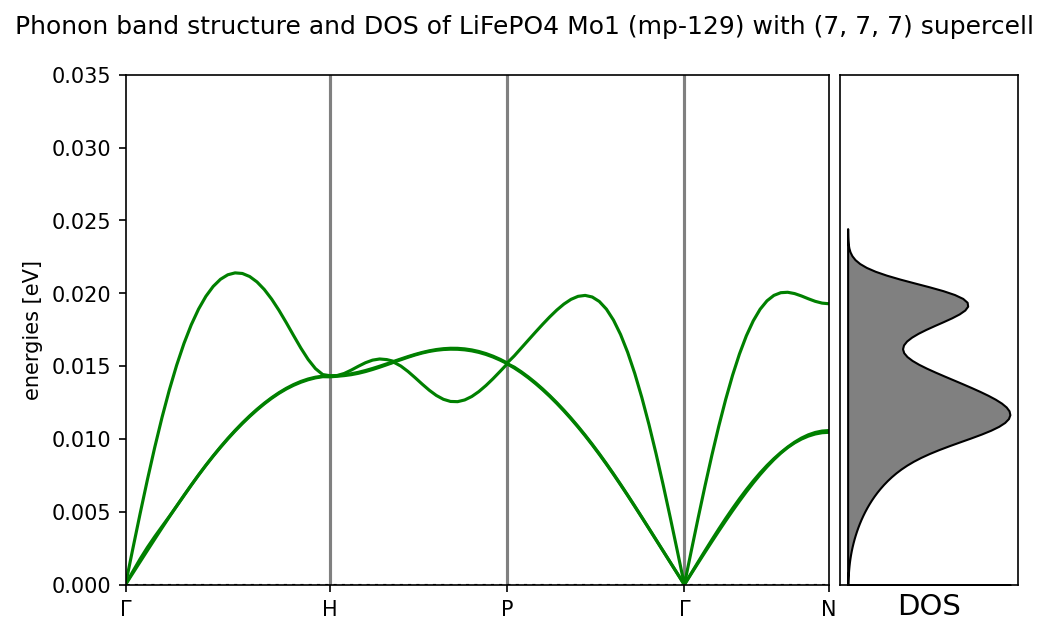

In [19]:
# Plot the band structure and DOS:
import matplotlib.pyplot as plt

plt.rc("figure", dpi=150)

fig = plt.figure(1, figsize=(7, 4))
bs_ax = fig.add_axes([0.12, 0.07, 0.67, 0.85])

emax = 0.035
bs.plot(ax=bs_ax, emin=0.0, emax=emax)

dos_ax = fig.add_axes([0.8, 0.07, 0.17, 0.85])
dos_ax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color="grey", edgecolor="black", lw=1)

dos_ax.set_ylim(0, emax)
dos_ax.set_yticks([])
dos_ax.set_xticks([])
dos_ax.set_xlabel("DOS", fontsize=14)

fig.suptitle(
    f"Phonon band structure and DOS of LiFePO4 {mp_129.formula} ({mp_id}) with {supercell} supercell",
    fontsize=12,
    y=1.02,
)